# Imports

In [9]:
import numpy as np
import pandas as pd
import os
import datetime
import random
import itertools
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Setup

In [16]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # đảm bảo hash ngẫu nhiên của Python cũng được kiểm soát
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

seed_everything()

In [17]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-06-26 13:14:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-26 13:14:11 (114 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [18]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


# EDA & Preprocessing

In [19]:
dataset = "/kaggle/input/animals10/raw-img"
walk_through_dir(dataset)

There are 10 directories and 0 images in '/kaggle/input/animals10/raw-img'.
There are 0 directories and 2623 images in '/kaggle/input/animals10/raw-img/cavallo'.
There are 0 directories and 1820 images in '/kaggle/input/animals10/raw-img/pecora'.
There are 0 directories and 1446 images in '/kaggle/input/animals10/raw-img/elefante'.
There are 0 directories and 1668 images in '/kaggle/input/animals10/raw-img/gatto'.
There are 0 directories and 1862 images in '/kaggle/input/animals10/raw-img/scoiattolo'.
There are 0 directories and 3098 images in '/kaggle/input/animals10/raw-img/gallina'.
There are 0 directories and 4821 images in '/kaggle/input/animals10/raw-img/ragno'.
There are 0 directories and 1866 images in '/kaggle/input/animals10/raw-img/mucca'.
There are 0 directories and 4863 images in '/kaggle/input/animals10/raw-img/cane'.
There are 0 directories and 2112 images in '/kaggle/input/animals10/raw-img/farfalla'.


In [20]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    filepaths = []
    extensions = ['jpg', 'jpeg', 'png','JPG','PNG']
    for ext in extensions:
        filepaths.extend(image_dir.glob(f'**/*.{ext.lower()}'))
        filepaths.extend(image_dir.glob(f'**/*.{ext.upper()}'))

    labels = list(map(lambda x: x.parent.name, filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')


    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

/tmp/ipython-input-21-2237132461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/tmp/ipython-input-21-2237132461.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


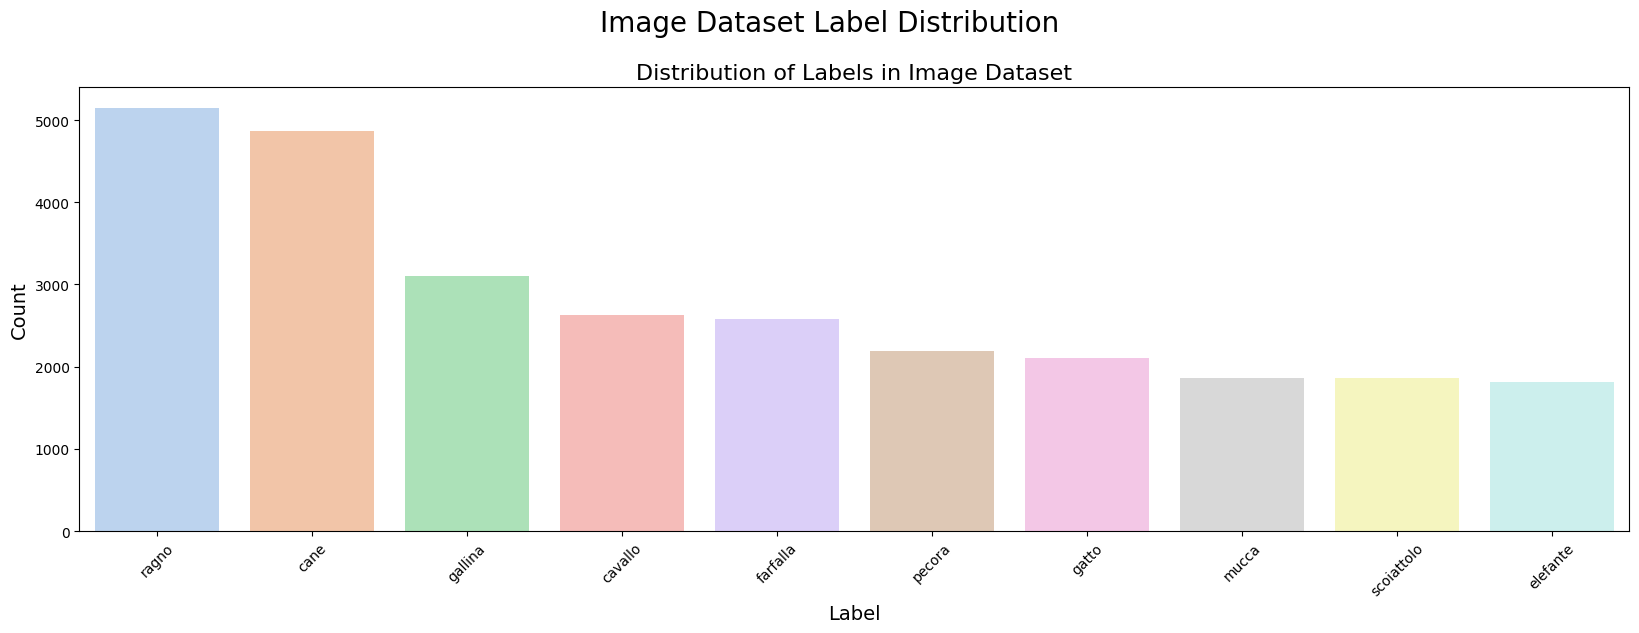

In [21]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
# làm sạch dữ liệu
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

# Get the value counts for each label
label_counts = image_df['Label'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)
fig.suptitle('Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)
plt.show()

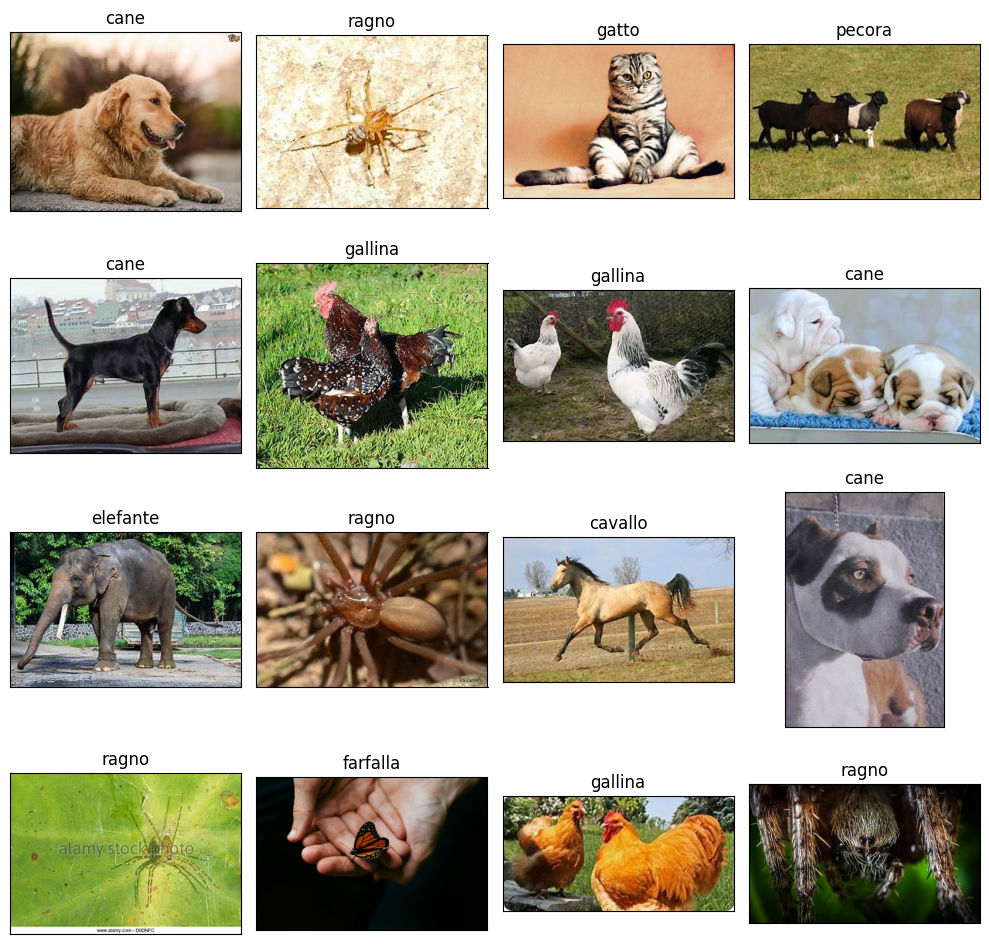

In [22]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [23]:
def random_sample(directory, exts=('.jpg', '.jpeg', '.png', '.JPG')):
    files = [f for f in os.listdir(directory) if f.endswith(exts)]
    if not files:
        raise ValueError(f"No image files found in {directory}")
    return os.path.join(directory, random.choice(files))


def compute_ela_cv(path, quality=90, scale=15):
  """
  Tính ảnh Error Level Analysis (ELA) từ ảnh đầu vào.

  Parameters:
      path (str): Đường dẫn ảnh gốc.
      quality (int): Mức chất lượng JPEG (0–100), càng thấp càng nén mạnh.
      scale (int): Hệ số phóng đại độ chênh lệch (giúp thấy rõ sai khác).

  Returns:
      np.array: Ảnh ELA dưới dạng mảng NumPy.
  """
  # Bước 1: Đọc ảnh gốc
  original = cv2.imread(path)
  if original is None:
      raise FileNotFoundError(f"Could not load image at path: {path}")

  # Bước 2: Lưu ảnh tạm dưới dạng JPEG nén lại
  temp_filename = 'temp_ela.jpg'
  cv2.imwrite(temp_filename, original, [cv2.IMWRITE_JPEG_QUALITY, quality])

  # Bước 3: Đọc lại ảnh nén
  compressed = cv2.imread(temp_filename)

  # Bước 4: Tính độ chênh lệch tuyệt đối giữa ảnh gốc và ảnh nén
  diff = cv2.absdiff(original, compressed)

  # Bước 5: Phóng đại sai khác để dễ quan sát
  ela_image = np.clip(diff * scale, 0, 255).astype(np.uint8)

  # Chuyển từ BGR sang RGB để matplotlib hiển thị đúng màu
  ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

  return ela_image

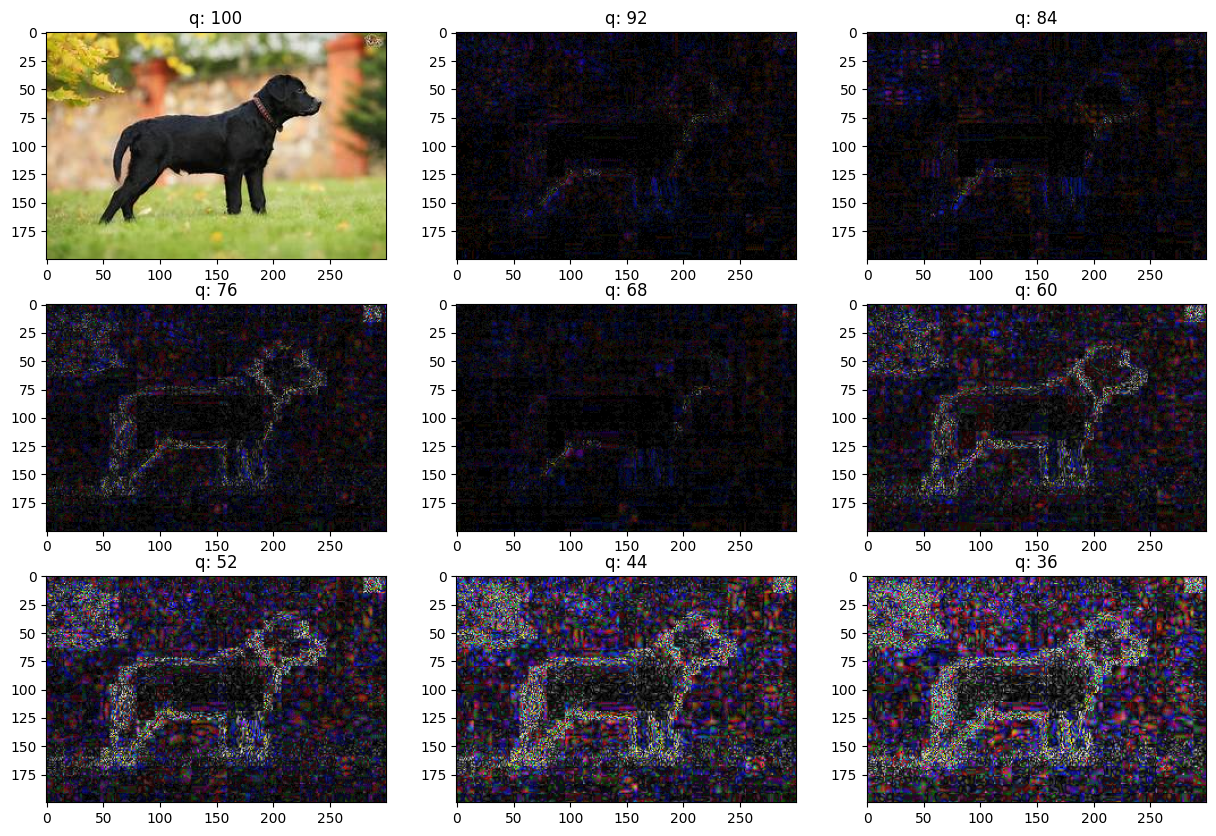

In [24]:
# View random sample from the dataset
p = random_sample('/kaggle/input/animals10/raw-img/cane')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Modeling

# CNN EfficientNetB0

In [25]:
# callback TensorBoard để lưu logs của một lần chạy huấn luyện
import datetime
import os
from tensorflow.keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = TensorBoard(log_dir=log_dir)
  print(f"Đang lưu logs của TensorBoard vào: {log_dir}")
  return tensorboard_callback

In [34]:
# HÀM CREATE_DL_PIPELINE
def create_dl_pipeline(df, class_names, image_size, batch_size, model_preprocessor, use_augmentation=False):
    filepaths = df['Filepath'].values
    labels = pd.get_dummies(df['Label'])[class_names].values
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    AUTOTUNE = tf.data.AUTOTUNE

    def load_and_resize(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, image_size)
        return img, label

    dataset = dataset.map(load_and_resize, num_parallel_calls=AUTOTUNE)

    if use_augmentation:
        augment = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.2)
        ])
        dataset = dataset.map(lambda img, lbl: (augment(img), lbl), num_parallel_calls=AUTOTUNE)

    dataset = dataset.map(lambda img, lbl: (model_preprocessor(img), lbl), num_parallel_calls=AUTOTUNE)

    if use_augmentation:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    return dataset

In [35]:
# Phân chia dữ liệu
train_val_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_val_df['Label'])

print(f"Tổng số ảnh: {len(image_df)}")
print(f"Số lượng ảnh trong tập huấn luyện: {len(train_df)}")
print(f"Số lượng ảnh trong tập validation: {len(val_df)}")
print(f"Số lượng ảnh trong tập kiểm thử: {len(test_df)}")

# Định nghĩa các tham số chung
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = sorted(train_df['Label'].unique())
print(f"\nCác lớp được phát hiện: {CLASS_NAMES}")

Tổng số ảnh: 28149
Số lượng ảnh trong tập huấn luyện: 18015
Số lượng ảnh trong tập validation: 4504
Số lượng ảnh trong tập kiểm thử: 5630

Các lớp được phát hiện: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
# A. Chuẩn bị dữ liệu bằng pipeline DL
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocessor
train_ds = create_dl_pipeline(train_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor, use_augmentation=True)
val_ds = create_dl_pipeline(val_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor)
test_ds = create_dl_pipeline(test_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor)

# B. Xây dựng mô hình
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SIZE, 3),
    pooling='max'
)
pretrained_model.trainable = False

# Định nghĩa Callbacks
checkpoint_path = "efficientnetb0_best_model.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      monitor="val_accuracy",
                                      save_best_only=True,
                                      save_weights_only=True, # Chỉ lưu trọng số là đủ
                                      mode='max',
                                      verbose=1)

early_stopping = EarlyStopping(monitor="val_loss",
                             patience=10, # Tăng patience một chút
                             restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=5, # Giảm LR nếu val_loss không cải thiện sau 5 epochs
                            min_lr=1e-6)

# Xây dựng mô hình hoàn chỉnh
inputs = layers.Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
x = pretrained_model(inputs, training=False)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax', name="output_layer")(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        checkpoint_callback,
        early_stopping,
        reduce_lr,
        create_tensorboard_callback("training_logs", "efficientnet_b0_transfer_learning")
    ]
)

print("\nĐánh giá trên tập test sau khi huấn luyện:")
model.load_weights(checkpoint_path) # Tải lại trọng số tốt nhất
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,250,669 (16.22 MB)

 Trainable params: 200,330 (782.54 KB)

 Non-trainable params: 4,050,339 (15.45 MB)

Đang lưu logs của TensorBoard vào: training_logs/efficientnet_b0_transfer_learning/20250626-131951
Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3656 - loss: 2.1647
Epoch 1: val_accuracy improved from -inf to 0.93739, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 281s 442ms/step - accuracy: 0.3659 - loss: 2.1635 - val_accuracy: 0.9374 - val_loss: 0.2390 - learning_rate: 1.0000e-04
Epoch 2/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7597 - loss: 0.7609
Epoch 2: val_accuracy improved from 0.93739 to 0.95138, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 270s 366ms/step - accuracy: 0.7598 - loss: 0.7607 - val_accuracy: 0.9514 - val_loss: 0.1607 - learning_rate: 1.0000e-04
Epoch 3/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8256 - loss: 0.5519
Epoch 3: val_accuracy improved from 0.95138 to 0.96226, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Dự đoán trên tập test
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)

# 2. Lấy nhãn thật từ test_ds
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy().argmax(axis=1))
y_true = np.array(y_true)

# 3. Đánh giá Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy EfficientNet: {accuracy:.4f}")

# 4. Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - EfficientNet")
plt.show()


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# Lưu lại kết quả EfficientNet để so sánh
efficientnet_result = {
    "Model": "EfficientNetB0",
    "Accuracy": accuracy,
    "Report": classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
}

import pandas as pd
report_df = pd.DataFrame(efficientnet_result["Report"]).transpose()
report_df.to_csv("efficientnet_report.csv")